## Проектная работа по курсу: анализ бизнес-показателей

Задача: провести маркетинговый анализ данных развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Нужно разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Требуется изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('D:\\ds\\visits_info_short.csv')
orders = pd.read_csv('D:\\ds\\orders_info_short.csv')
costs = pd.read_csv('D:\\ds\\costs_info_short.csv')
pd.set_option('display.max_columns', None)

In [4]:
def get_info(dataframe):
    display(dataframe.head(5))
    print()
    dataframe.info()
    print()
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print()
    print('Пропусков в колонках:')
    print(dataframe.isna().sum())

def prep(dataframe):
    dataframe = dataframe.drop_duplicates()
    dataframe.columns = dataframe.columns.str.lower()
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    return dataframe

In [5]:
visits = prep(visits)
orders = prep(orders)
costs = prep(costs)

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [7]:
get_info(visits)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



<class 'pandas.core.frame.DataFrame'>
Int64Index: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 16.6+ MB

Явных дубликатов: 0

Пропусков в колонках:
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


In [7]:
get_info(orders)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



<class 'pandas.core.frame.DataFrame'>
Int64Index: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB
None

Явных дубликатов: 0

Пропусков в колонках:
user_id     0
event_dt    0
revenue     0
dtype: int64


In [8]:
get_info(costs)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 56.2+ KB
None

Явных дубликатов: 0

Пропусков в колонках:
dt         0
channel    0
costs      0
dtype: int64


### Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
def get_profiles(sessions, orders, ad_costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date  
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
        
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date 
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days  
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
        
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)  
    if 'cohort' in dimensions: 
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    )

In [14]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer']) 
        
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )   
    plt.tight_layout()
    plt.show()

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Формирую таблицу с профилями пользователей.

In [18]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [19]:
print('Даты проведения кампаний:')
print(costs['dt'].min())
print(costs['dt'].max())
print('Даты активности пользователей:')
print(profiles['first_ts'].min())
print(profiles['first_ts'].max())

Даты проведения кампаний:
2019-05-01
2019-10-27
Даты активности пользователей:
2019-05-01 00:00:41
2019-10-27 23:59:04


Самая первая и последняя проведенные рекламные кампании стартовали 1 мая и 27 октября соответственно. Этими же датами ограничивается и активность пользователей в предоставленной выборке.

In [21]:
def payer_ratio(index):
    table = profiles.pivot_table(index=index, values='payer', aggfunc=['count', 'sum', 'mean'])
    table.columns = ['total_users', 'total_payers', 'payers_ratio']
    table = table.sort_values(by='payers_ratio')
    table['payers_ratio'] = table['payers_ratio'].apply(lambda x: "{:.2%}".format(x))
    return table

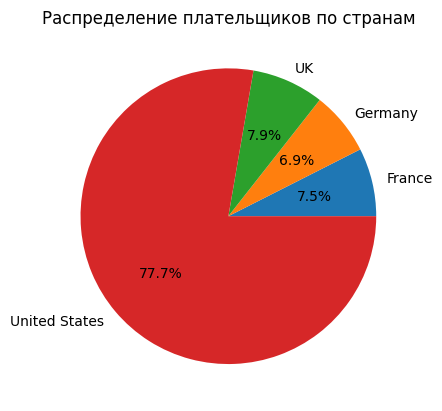

In [20]:
profiles.groupby('region')['payer'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Распределение плательщиков по странам');

На данной диаграмме представлено распределение пользователей, совершивших хотя бы одну покупку в приложении, по странам. Как видно, подавляющее большинство находится в США - 78%. Доли других стран примерно равны и составляют 7-8%.

In [22]:
payer_ratio('region')

,total_users,total_payers,payers_ratio
region,,,
France,17450,663,3.80%
UK,17575,700,3.98%
Germany,14981,616,4.11%
United States,100002,6902,6.90%


В целом доля плательщиков среди пользователей по всем странам составляет 3,8 - 6,9%. Максимально это значение также в США, показатели трёх других стран также минимальны и примерно равны.

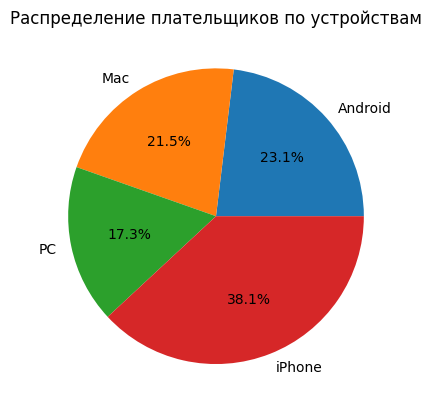

In [22]:
profiles.groupby('device')['payer'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Распределение плательщиков по устройствам');

Как видно, среди устройств лидирует iPhone, но в целом доли распределены относительно равномерно.

In [23]:
payer_ratio('device')

,total_users,total_payers,payers_ratio
device,,,
PC,30455,1537,5.05%
Android,35032,2050,5.85%
iPhone,54479,3382,6.21%
Mac,30042,1912,6.36%


Доля плательщиков среди пользователей iPhone и Mac немного выше, но разница также не столь существенна. 

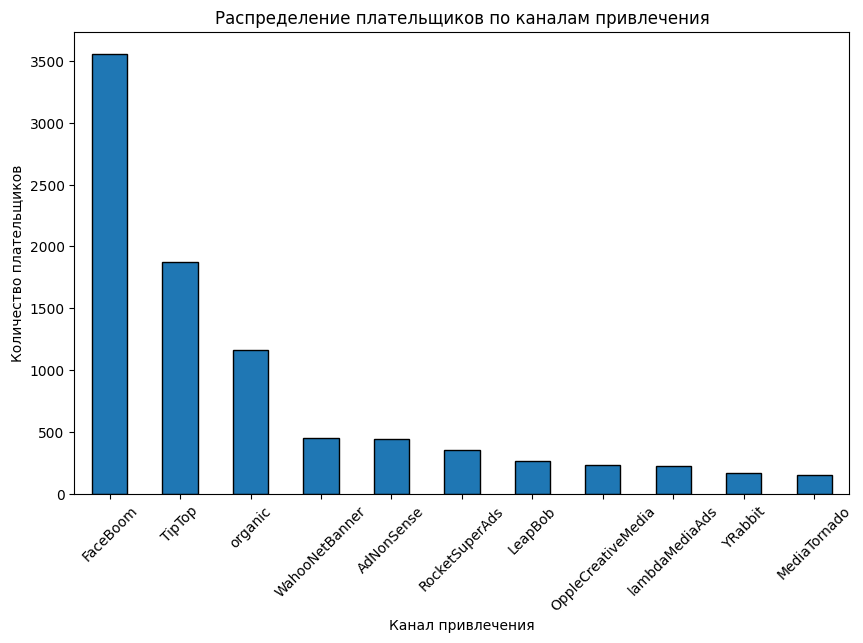

In [24]:
plt.figure(figsize=(10, 6))
profiles.groupby('channel')['payer'].sum().sort_values(ascending=False).plot(kind='bar', edgecolor='black')
plt.ylabel('Количество плательщиков')
plt.xlabel('Канал привлечения')
plt.title('Распределение плательщиков по каналам привлечения')
plt.xticks(rotation=45);

С существенным отрывом лидирует канал FaceBoom, следом TipTop. В первую тройку входит и organic: все остальные каналы, а их ещё 8, привлекли значительно меньшее количество плательщиков.

In [25]:
payer_ratio('channel')

,total_users,total_payers,payers_ratio
channel,,,
organic,56439,1160,2.06%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%
WahooNetBanner,8553,453,5.30%
RocketSuperAds,4448,352,7.91%
TipTop,19561,1878,9.60%
lambdaMediaAds,2149,225,10.47%


Доля плательщиков FaceBoom также является максимальной, а вот конверсия среди привлеченных с TipTop всего на 4 месте.

### Маркетинг

In [24]:
print(f'Потрачено на рекламу: {round(costs["costs"].sum())}$')
print(f'Получено выручки: {round(orders["revenue"].sum())}$')

Потрачено на рекламу: 105497$
Получено выручки: 215963$


В целом пока выглядит, что мы в плюсе.

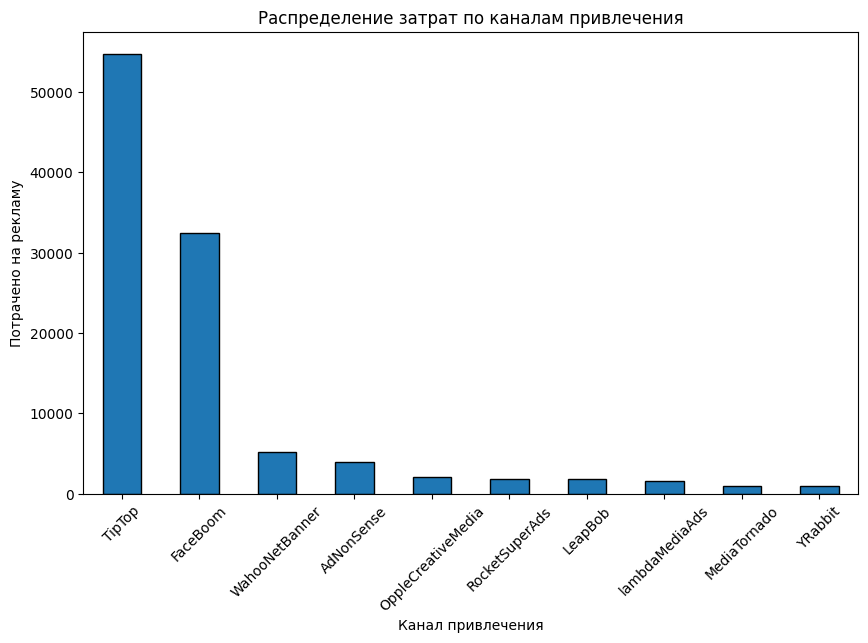

In [27]:
plt.figure(figsize=(10, 6))
costs.groupby('channel')['costs'].sum().sort_values(ascending=False).plot(kind='bar', edgecolor='black')
plt.ylabel('Потрачено на рекламу')
plt.xlabel('Канал привлечения')
plt.title('Распределение затрат по каналам привлечения')
plt.xticks(rotation=45);

Больше всего денег тратится на TipTop, а отдача от него не равносильно велика. Посмотрю как меняются расходы по периодам недель и месяцев. 

In [25]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

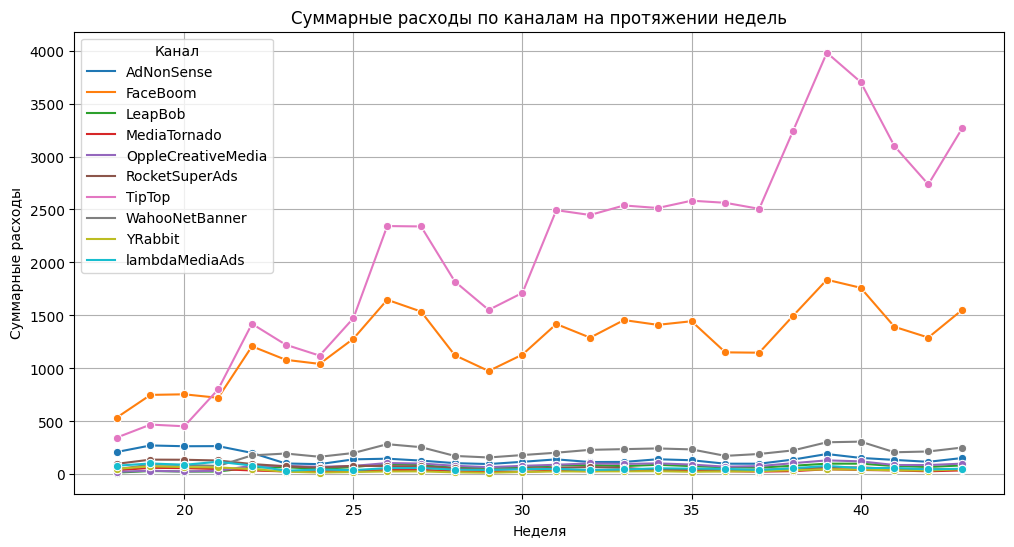

In [26]:
weeks = costs.groupby(['channel', 'week'])['costs'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=weeks, x='week', y='costs', hue='channel', marker='o')
plt.title('Суммарные расходы по каналам на протяжении недель')
plt.xlabel('Неделя')
plt.ylabel('Суммарные расходы')
plt.grid(True)
plt.legend(title='Канал', loc='upper left');

Начиная с 25ой недели расходы на рекламу в TipTop начали отрываться от расходов на FaceBoom и сильно увеличились.

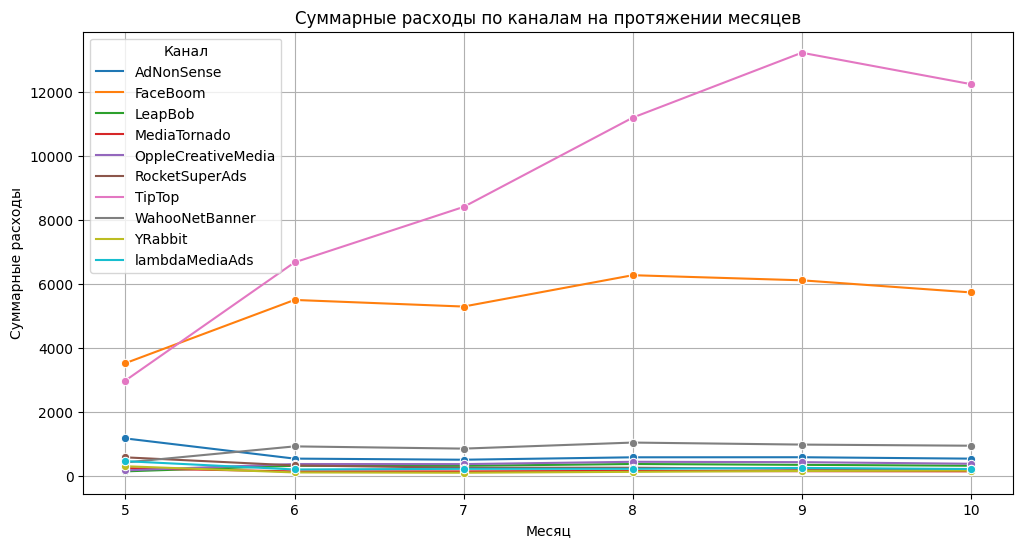

In [27]:
months = costs.groupby(['channel', 'month'])['costs'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=months, x='month', y='costs', hue='channel', marker='o')
plt.title('Суммарные расходы по каналам на протяжении месяцев')
plt.xlabel('Месяц')
plt.ylabel('Суммарные расходы')
plt.grid(True)
plt.legend(title='Канал', loc='upper left');

С июля по сентябрь расходы на TipTop увеличивались каждый месяц.

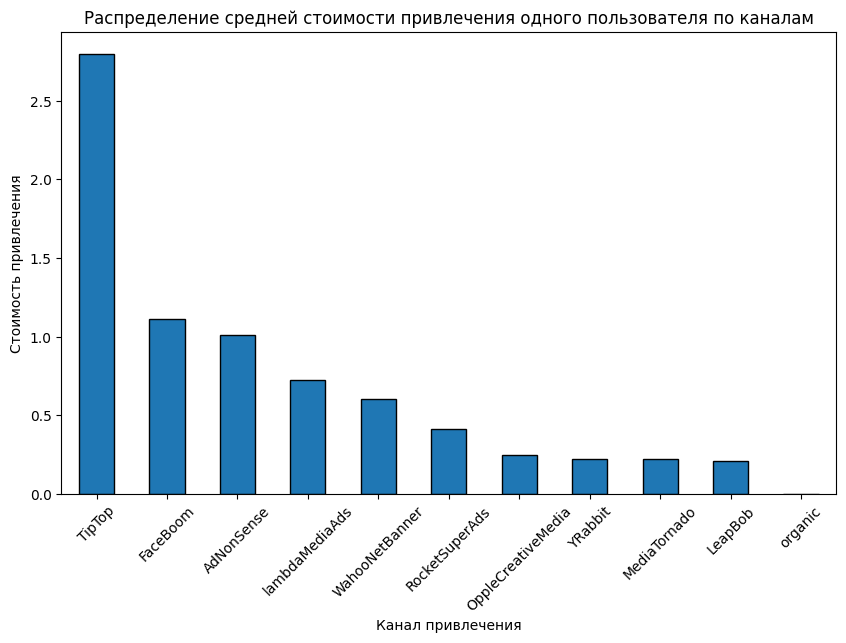

In [31]:
plt.figure(figsize=(10, 6))
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False).plot(kind='bar', edgecolor='black')
plt.ylabel('Стоимость привлечения')
plt.xlabel('Канал привлечения')
plt.title('Распределение средней стоимости привлечения одного пользователя по каналам')
plt.xticks(rotation=45);

Привлечение одного пользователя из TipTop обходится слишком дорого.

### Оценка окупаемости рекламы

В соответствии с условием задачи установлю момент анализа на 1 ноября 2019 года, а горизонт на 14 дней. Исключу из выборки органически привлеченных пользователей для того, чтоб точнее раскрыть картину с затратами на маркетинг.

In [28]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

Далее посмотрю на общий LTV и ROI по всем пользователям.

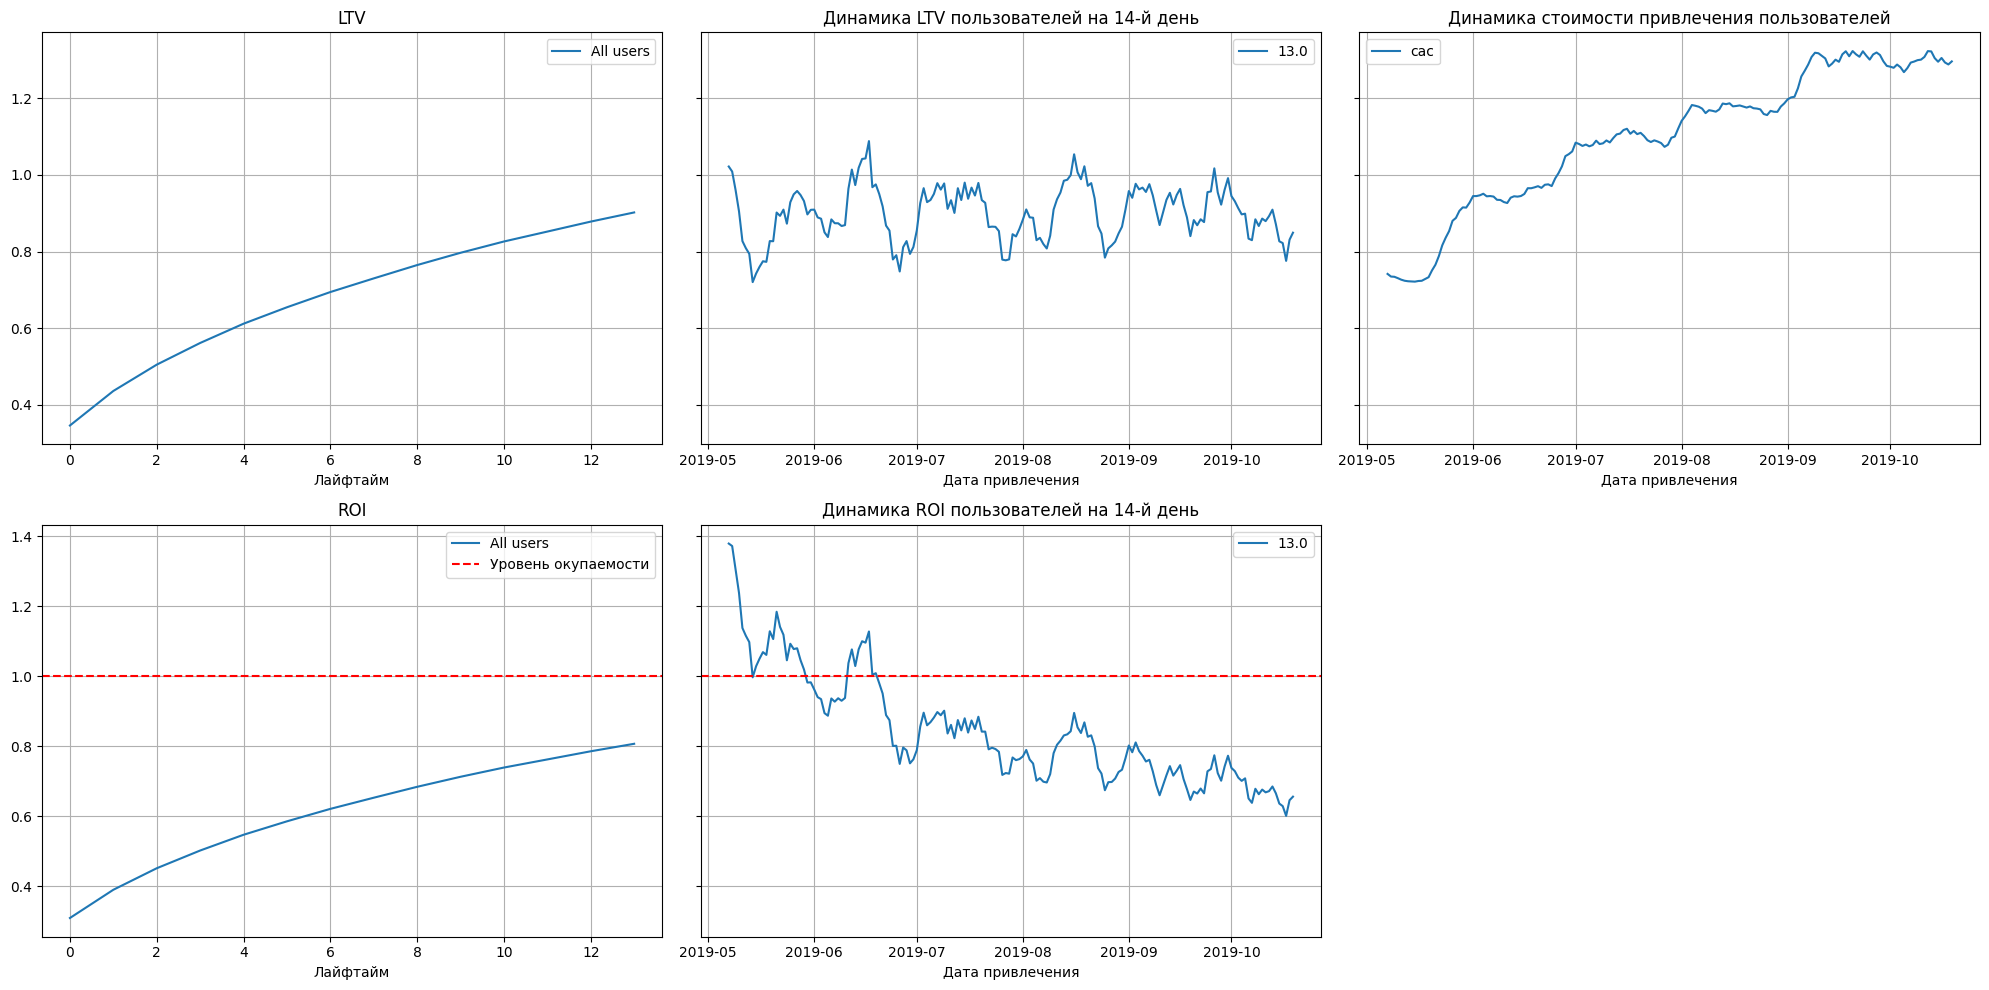

In [29]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Кривая CAC расположена выше кривой LTV, что свидетельствует о том, что затраты на привлечение в целом не отбиваются. Затраты на рекламу постоянно растут.<br>
Динамика LTV не имеет явных аномалий и достаточно стабильна.<br>
Стабильность LTV и рост CAC, может говорить о росте конкуренции на канале или увеличением бюджета по каналу.<br>
График ROI показывает, что возврат вложений в рекламу находится ниже уровня окупаемости.<br>
По динамике ROI видно, что момент убыточности наступал дважды: в конце июня и конце июля, после чего показатель стабильно снижается в зоне убыточности.

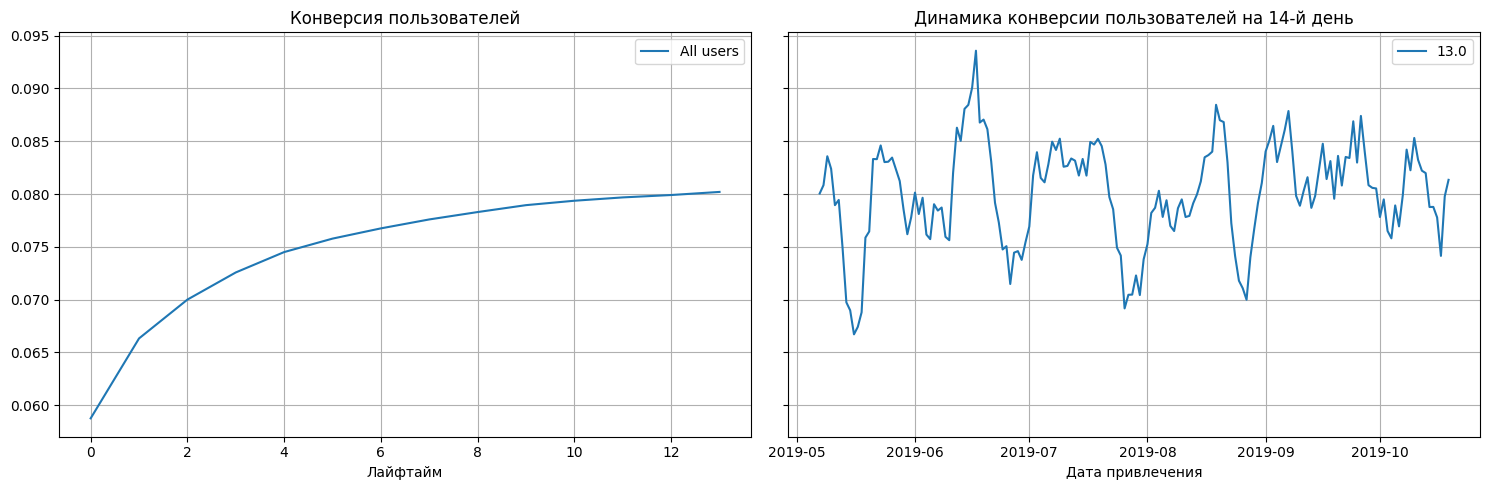

In [30]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_history, horizon_days)

Конверсия пользователей резко увеличивается в первые 6 дней лайфтайма, после чего рост процента конверсии замедляется.<br>
На графике динамики конверсии видно, что она резко увеличивалась до середины июня, после чего рост прекратился.

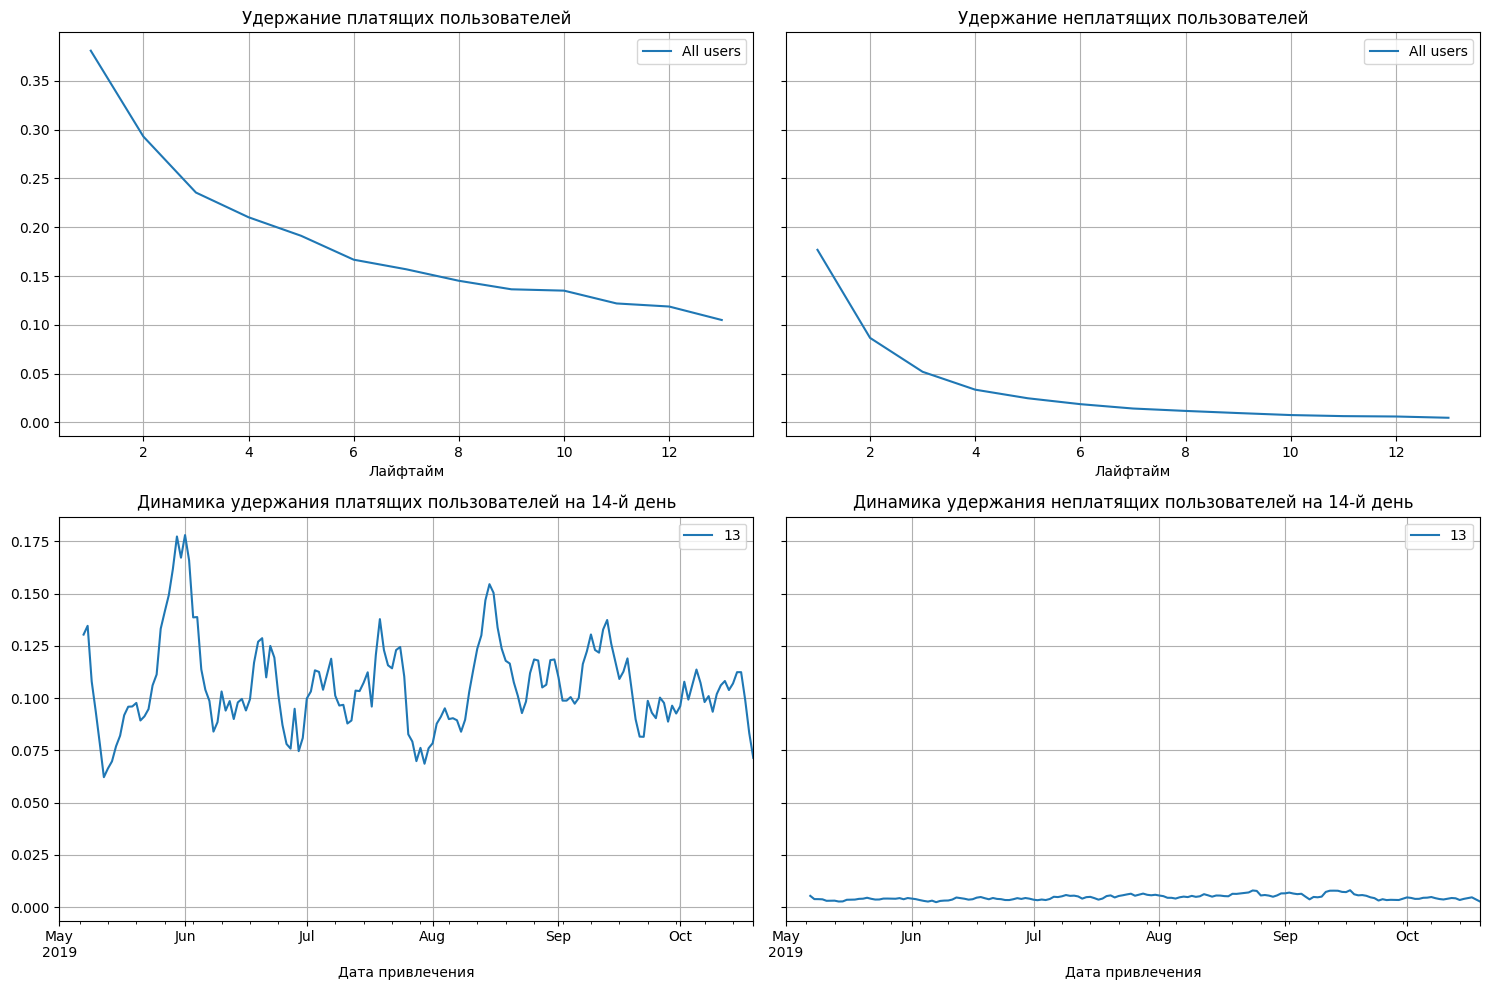

In [31]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days)

Удержание платящих пользователей удаётся лучше. Динамика показывает тенденцию к спаду удержания после июня.

Теперь анализ графиков с разбивкой по устройствам.

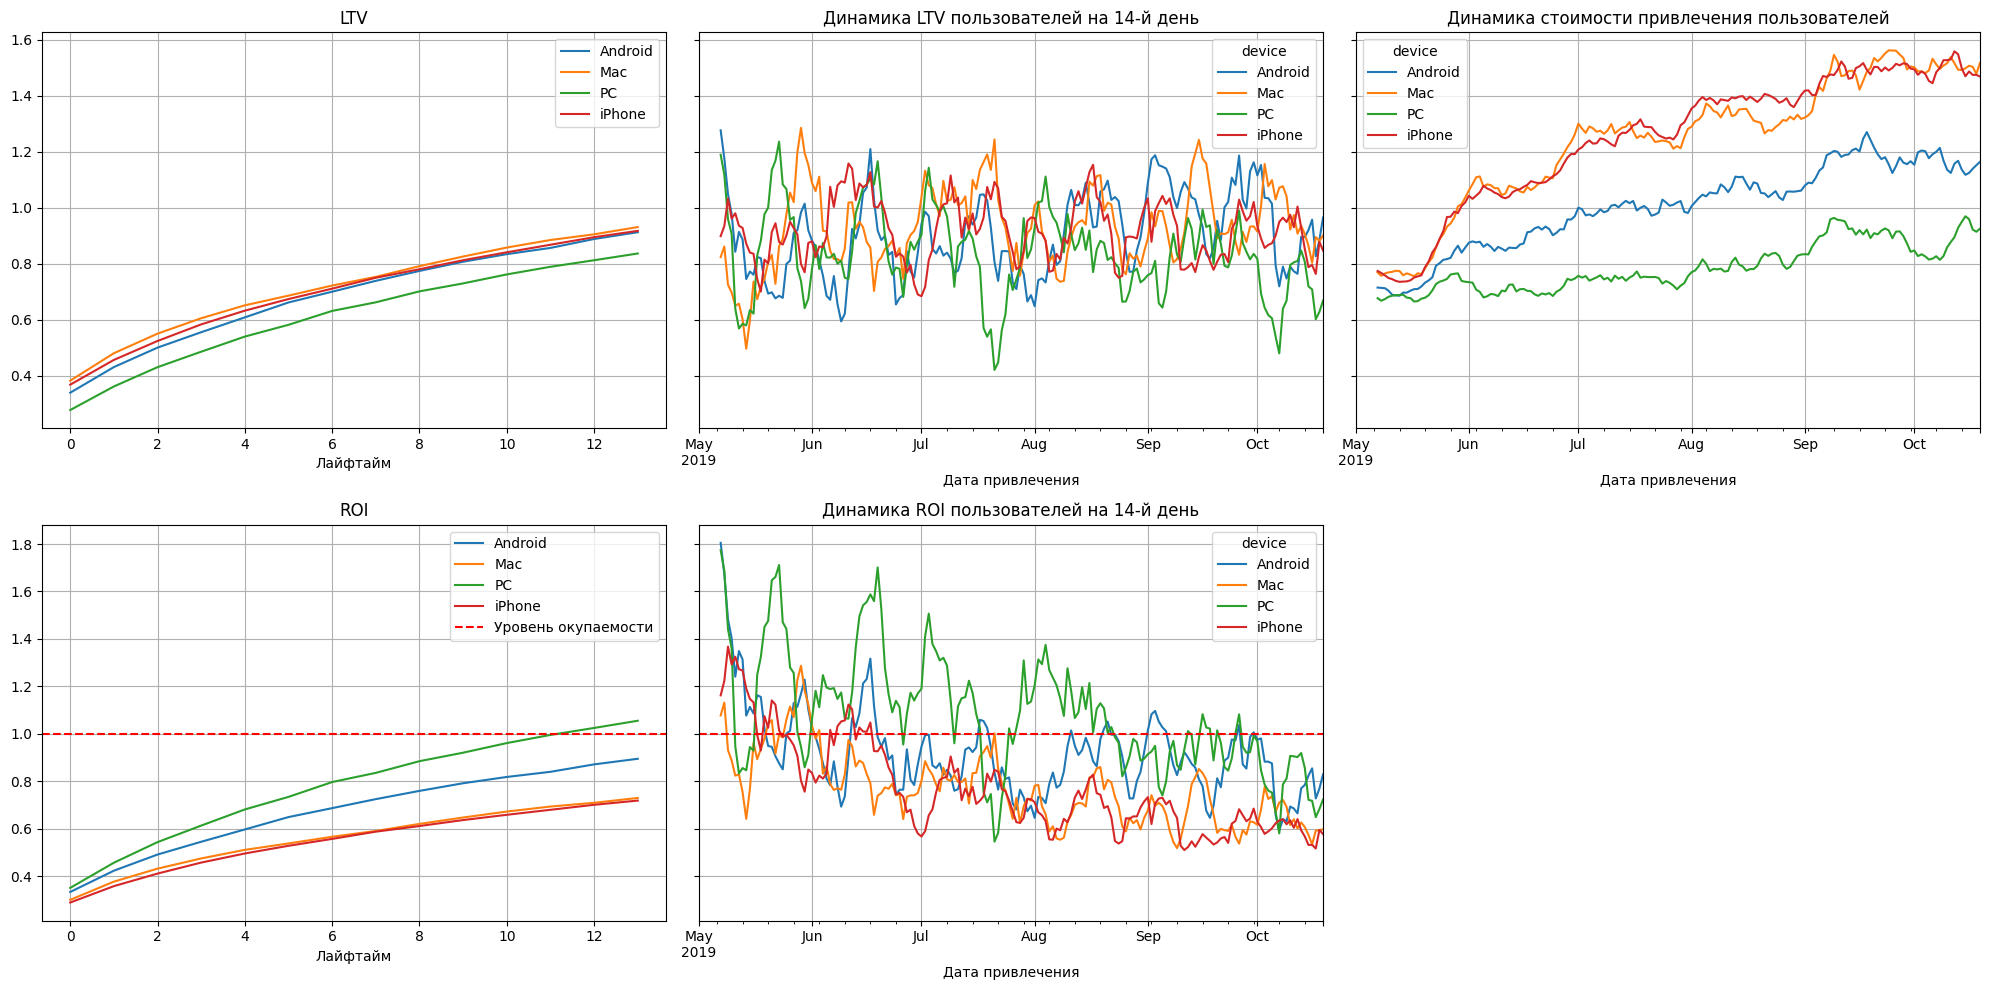

In [32]:
device_ltv_raw, device_ltv, device_ltv_history, device_roi, device_roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(device_ltv, device_ltv_history, device_roi, device_roi_history, horizon_days)

LTV пользователей всех устройств находится примерно на одном уровне, немного выбиваются пользователи PC.<br>
Также стоимость привлечения пользователей PC ниже прочих при, выше и их ROI, однако и он окончательно уходит в зону убыточности в конце августа. Самыми дорогими в привлечении являются пользователи Мас и iPhone, в течение почти всего наблюдаемого периода их ROI ниже уровня окупаемости.

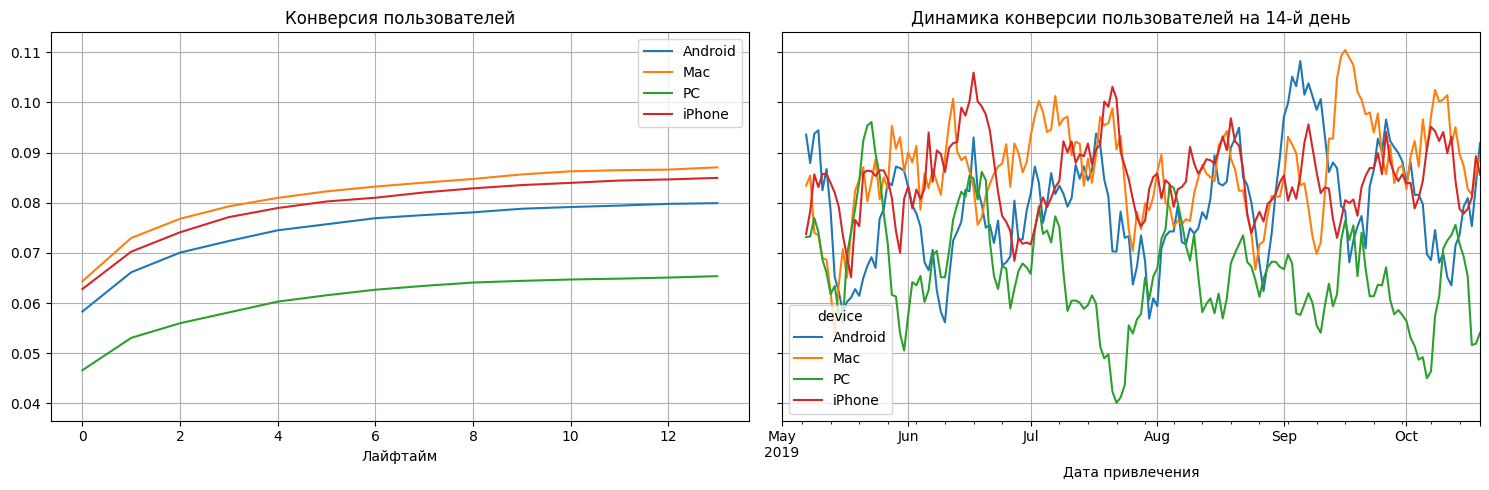

In [33]:
device_conversion_raw, device_conversion, device_conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(device_conversion, device_conversion_history, horizon_days)

Конверсия пользователей Mac и iPhone выше прочих.

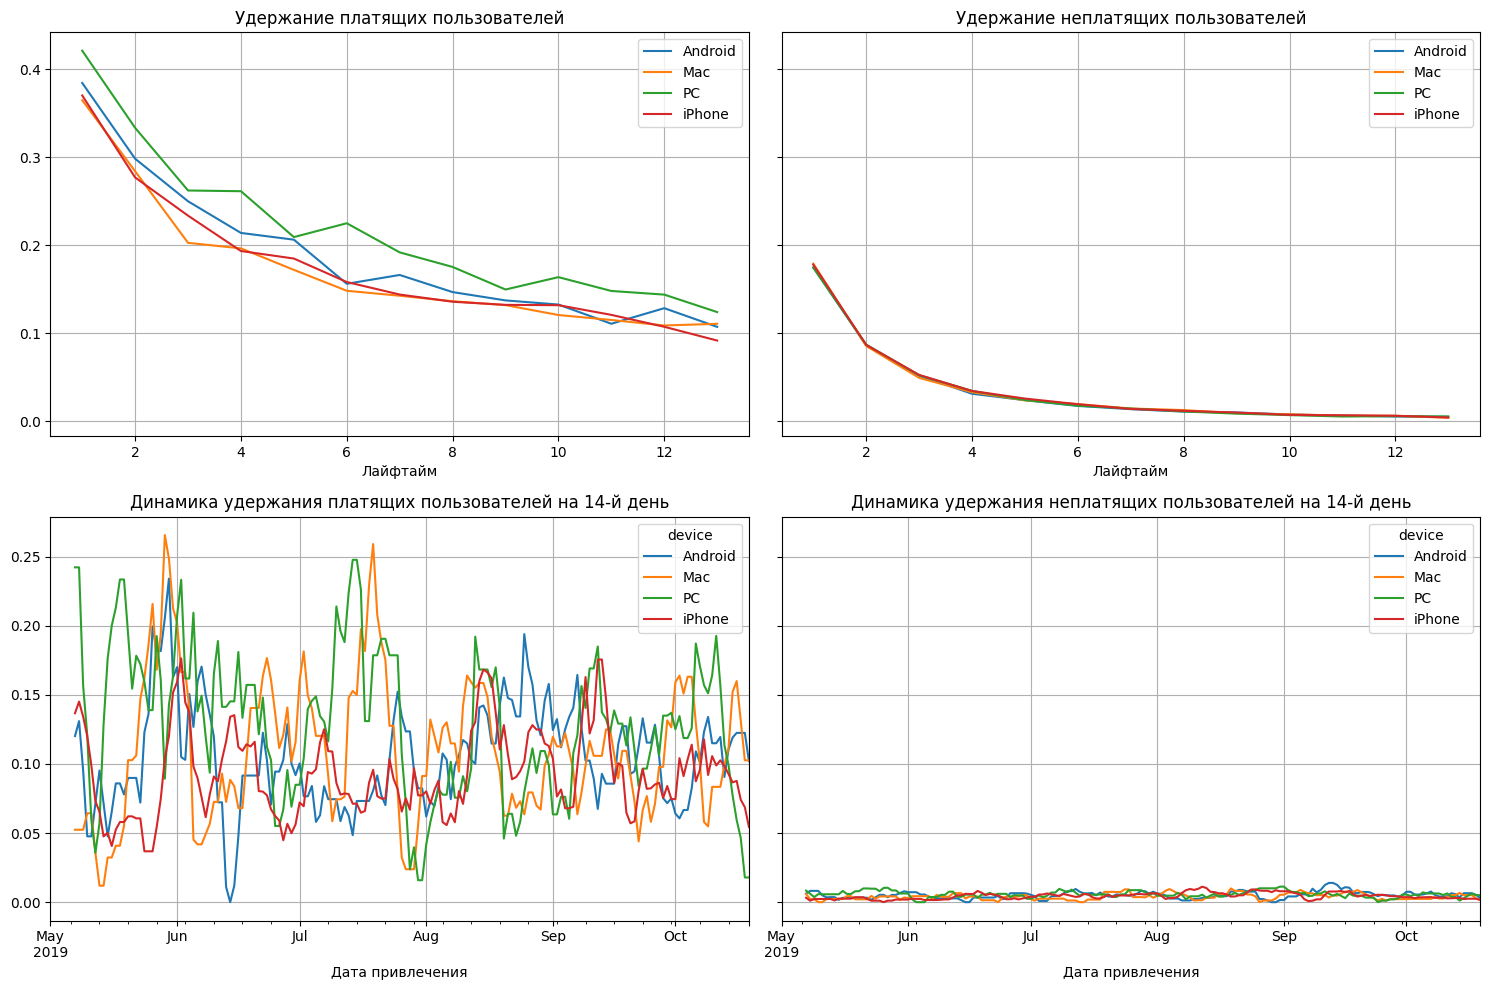

In [34]:
device_retention_raw, device_retention, device_retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(device_retention, device_retention_history, horizon_days)

Удержание пользователей Mac и iPhone чуть ниже прочих.

Далее разбивка по регионам.

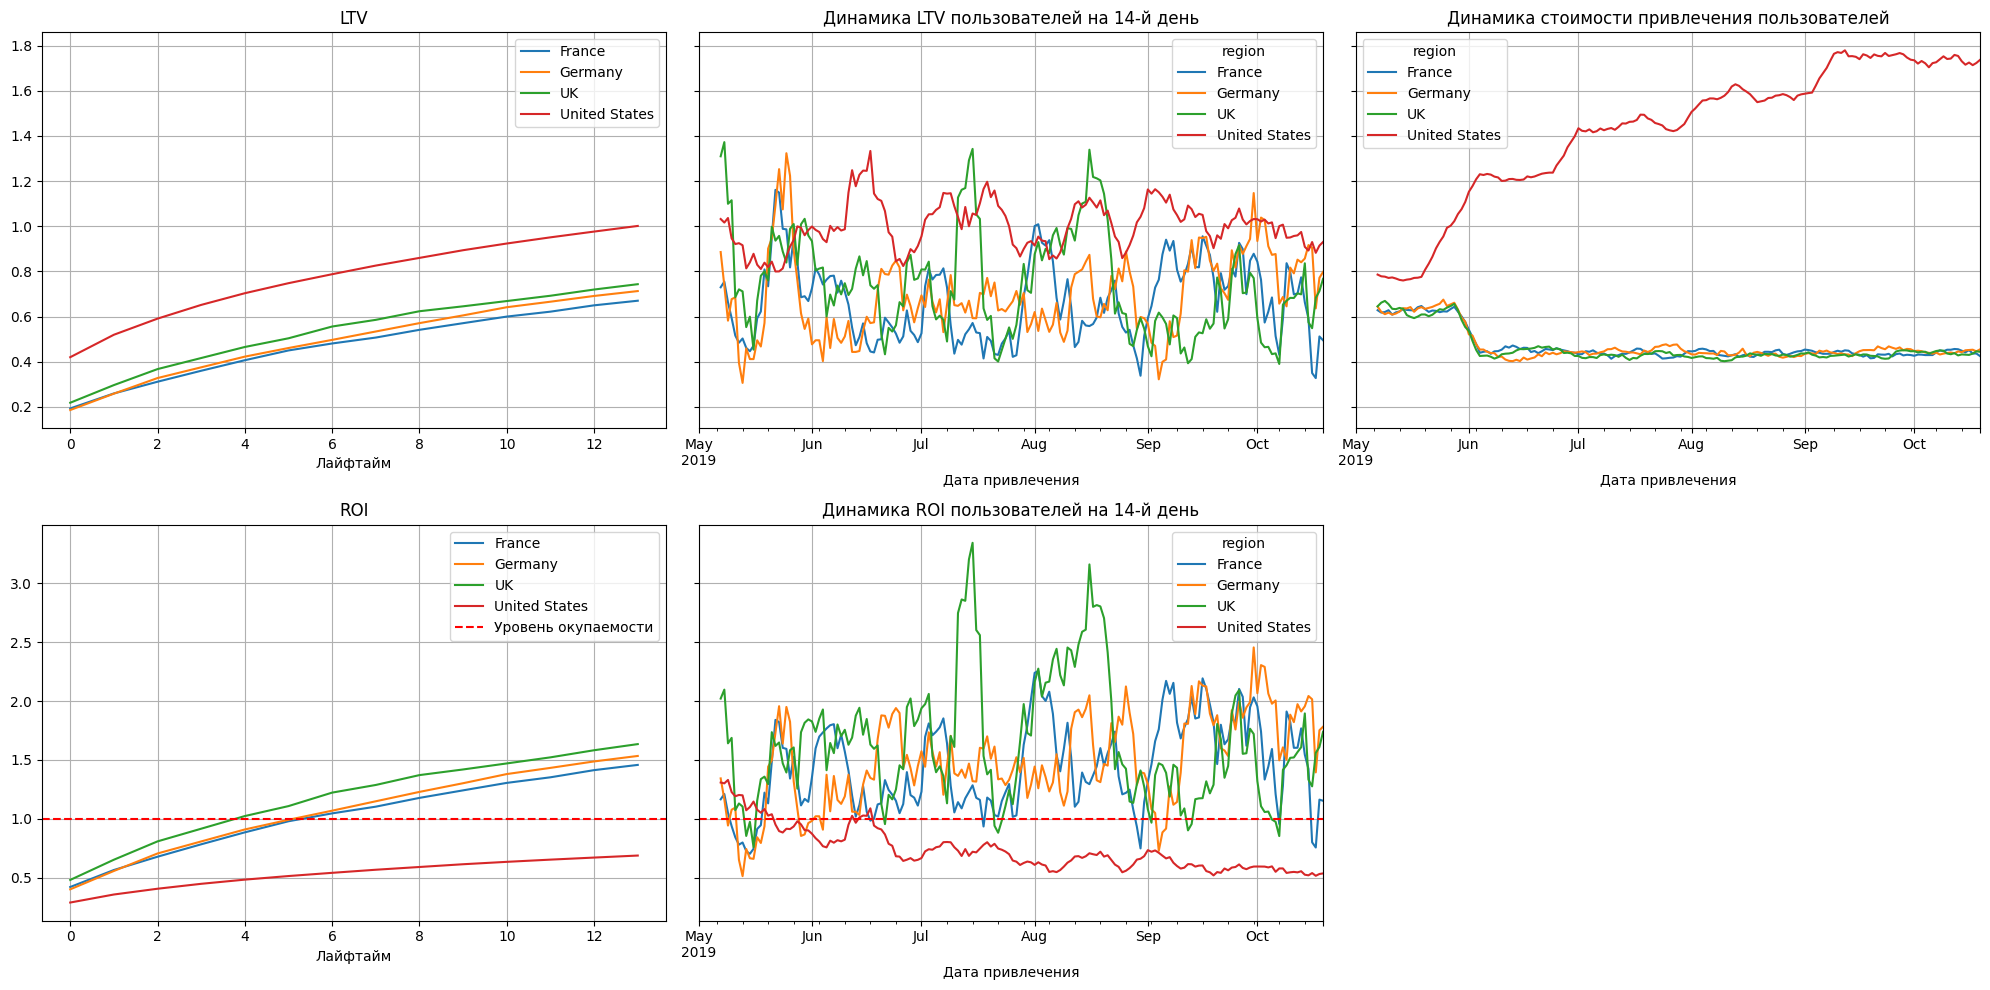

In [36]:
region_ltv_raw, region_ltv, region_ltv_history, region_roi, region_roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(region_ltv, region_ltv_history, region_roi, region_roi_history, horizon_days)

Видно, что регион США выделяется на фоне остальных. Стоимость привлечения пользователей из США существенно выше и имеет тенденцию к дальнейшему росту. Это единственный регион, чей ROI стабильно находится ниже порога окупаемости. Также можно отметить, что в конце мая стоимость привлечения в США начала активный рост, а стоимость привлечения в Европе немного понизилась. Хорошую окупаемость показывает регион UK.

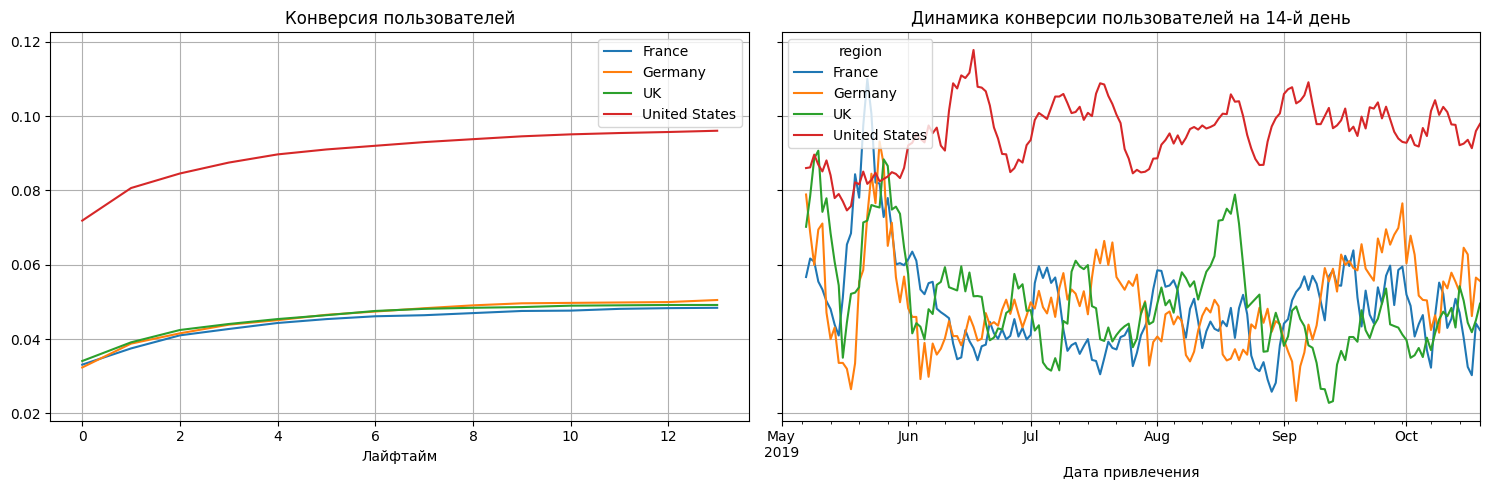

In [37]:
region_conversion_raw, region_conversion, region_conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_conversion(region_conversion, region_conversion_history, horizon_days)

Конверсия в регионе США выше прочих.

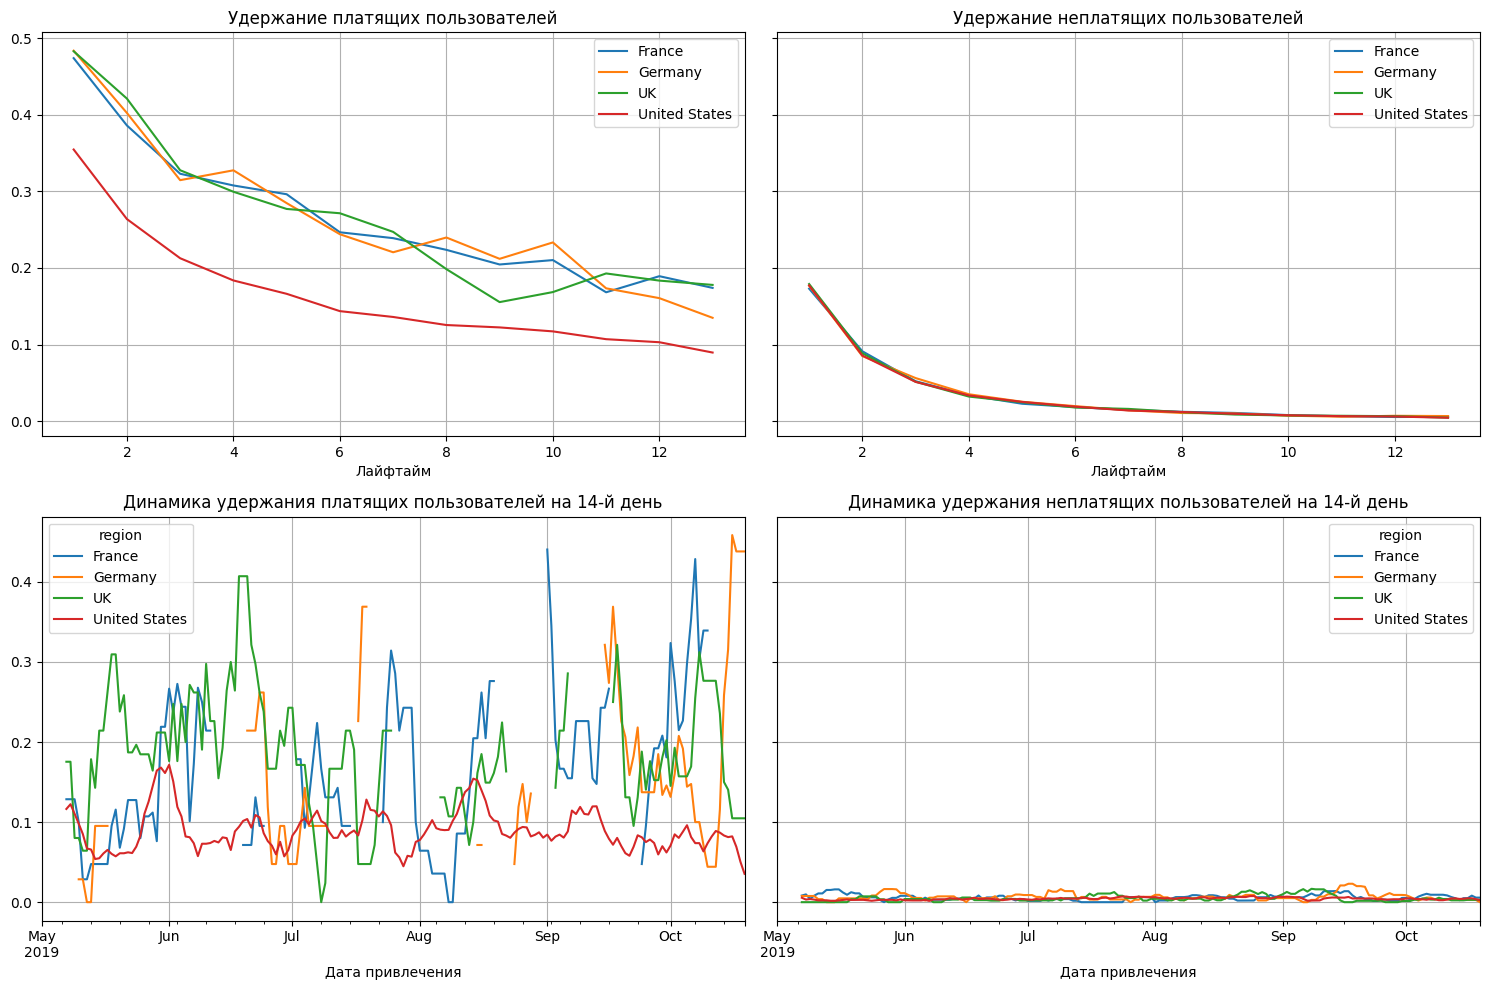

In [38]:
region_retention_raw, region_retention, region_retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(region_retention, region_retention_history, horizon_days)

Пользователи из США хуже удерживаются.

Далее разбивка по каналам привлечения.

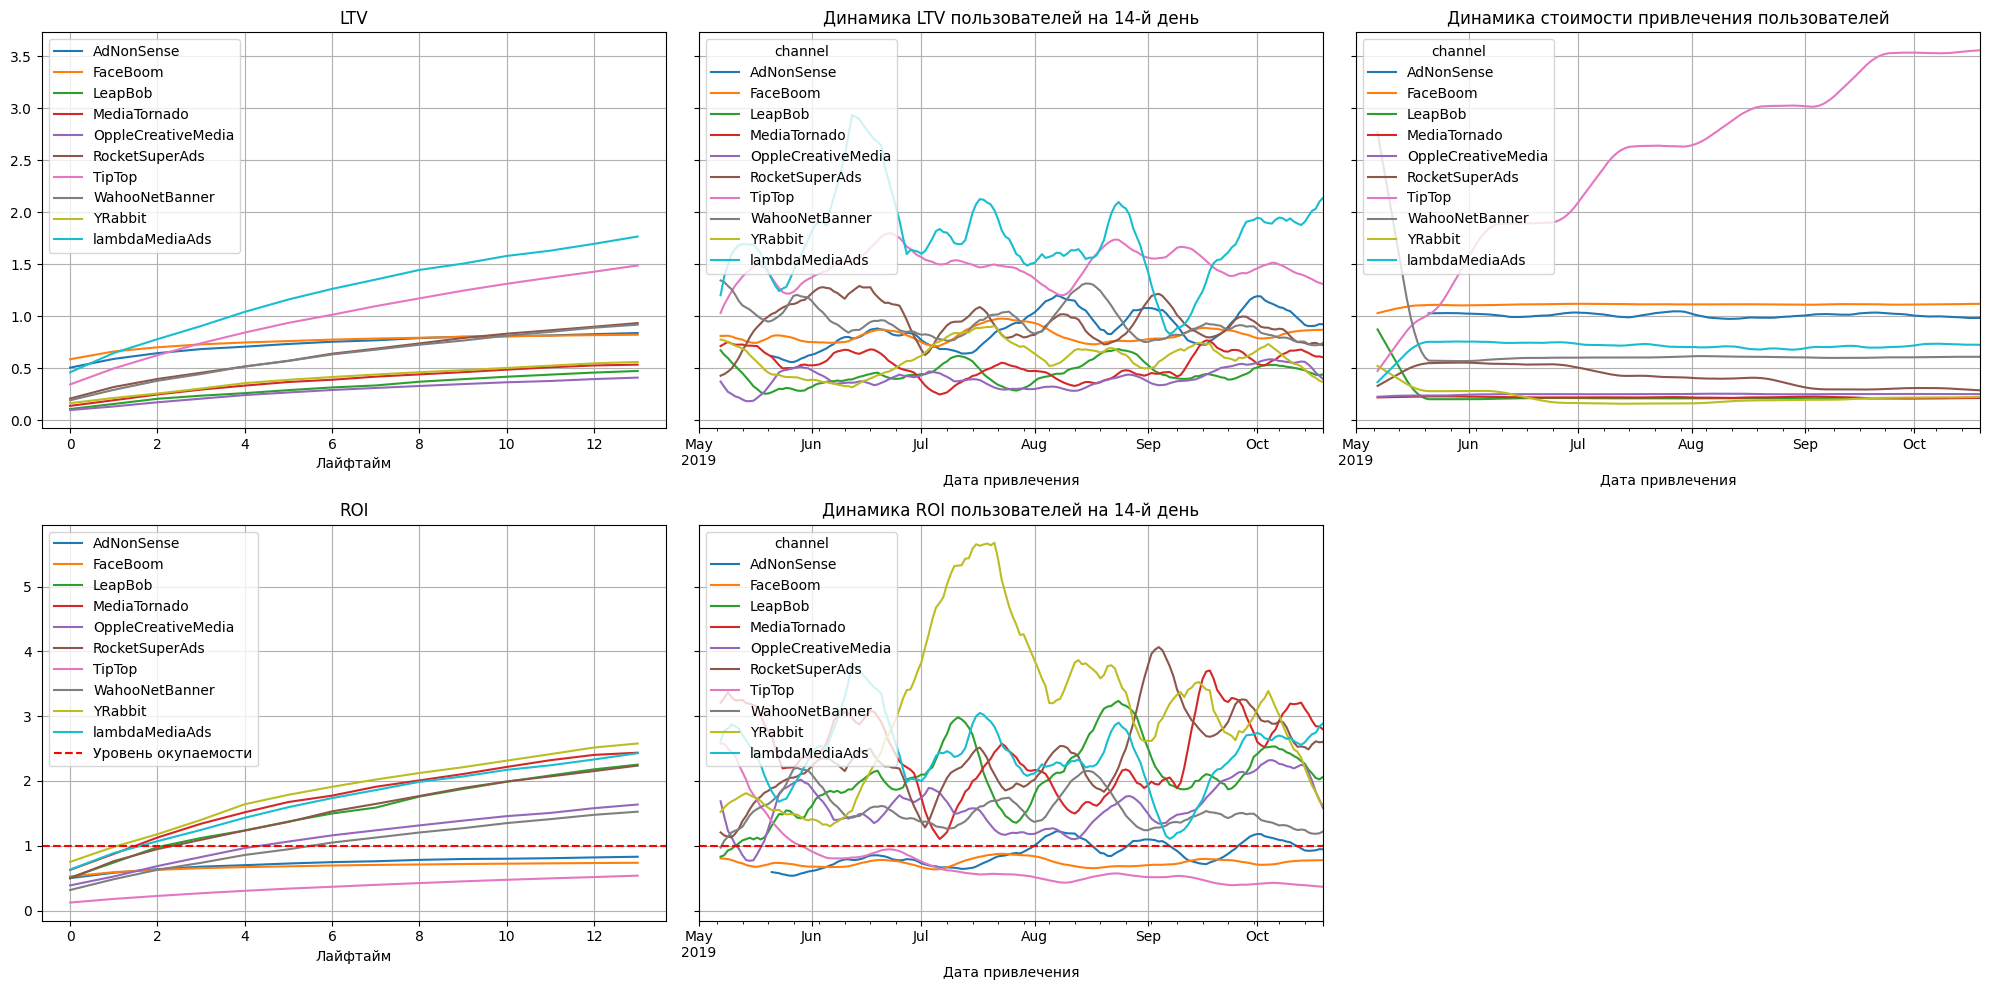

In [40]:
channel_ltv_raw, channel_ltv, channel_ltv_history, channel_roi, channel_roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])
channel_ltv_history_filtered = filter_data(channel_ltv_history, 15)
channel_roi_history_filtered = filter_data(channel_roi_history, 15)
plot_ltv_roi(channel_ltv, channel_ltv_history_filtered, channel_roi, channel_roi_history_filtered, horizon_days)

Затраты на привлечение пользователей из TipTop постоянно растут в то время как затраты на привлечение из всех остальных каналов остаются стабильными. ROI TipTop и FaceBoom стабильно находится в зоне убыточности. Самый высокий положительный ROI у сетей YRabbit, MediaTornado и lambdaMediaAds.

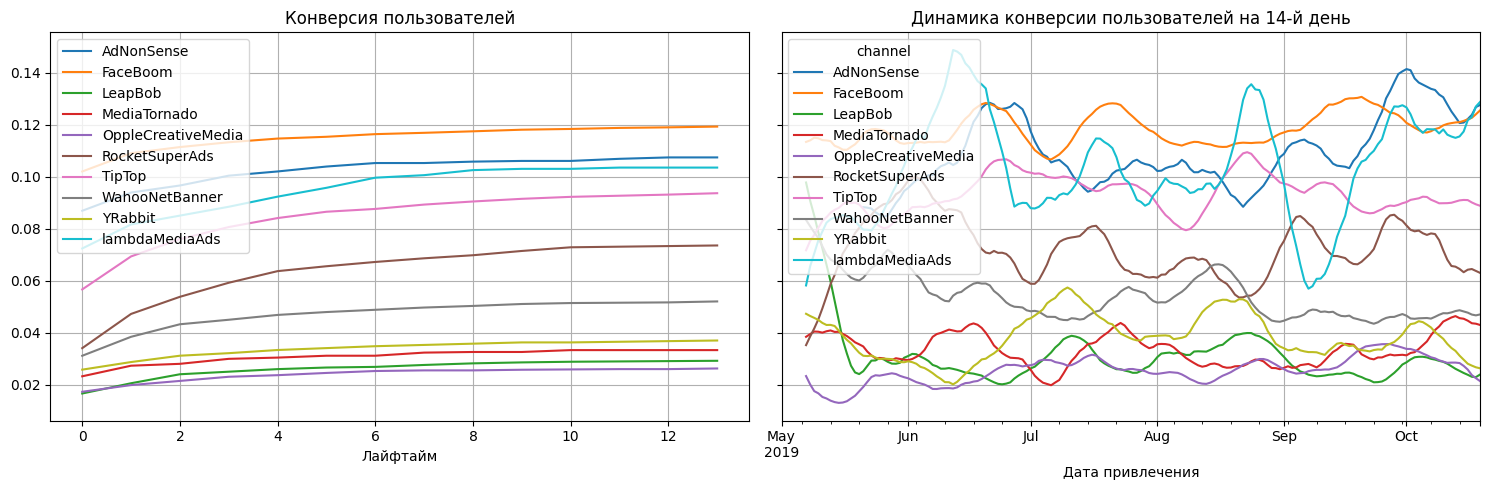

In [41]:
channel_conversion_raw, channel_conversion, channel_conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])
channel_conversion_history_filtered = filter_data(channel_conversion_history, 15)
plot_conversion(channel_conversion, channel_conversion_history_filtered, horizon_days)

Наивысшая конверсия у FaceBoom, при том довольно стабильная в динамике.

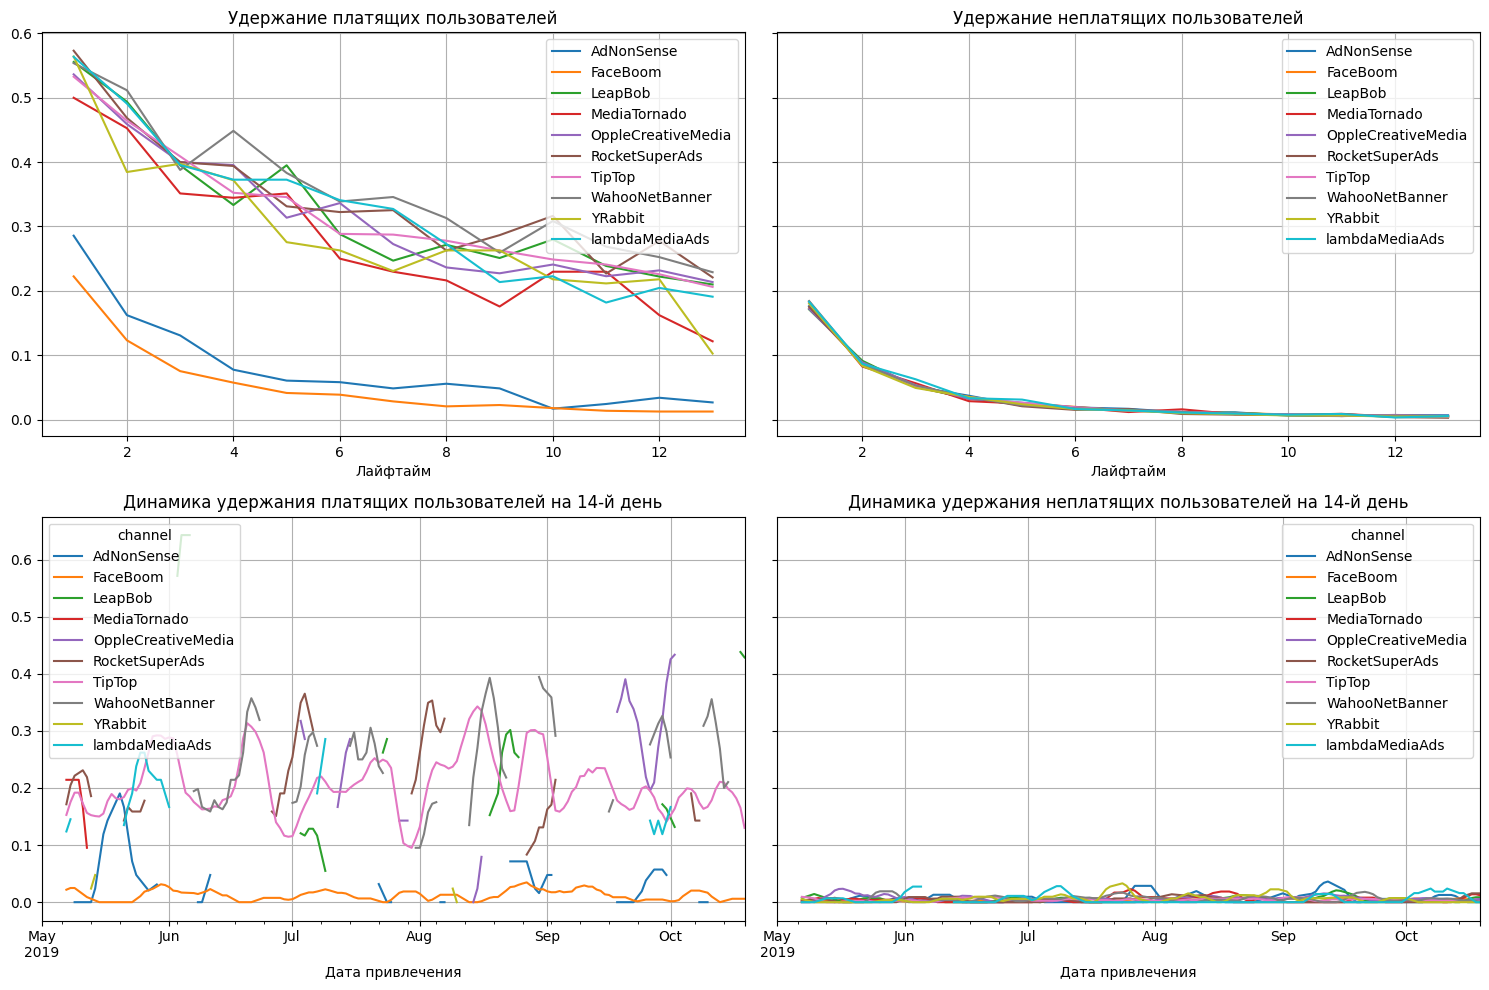

In [42]:
channel_retention_raw, channel_retention, channel_retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])
channel_retention_history_filtered = filter_data(channel_retention_history, 3)
plot_retention(channel_retention, channel_retention_history_filtered, horizon_days)

Также FaceBoom характеризуется наименьшим удержанием.

В целом можно сказать, что, начиная с июля, затраты на рекламу не окупаются. Основные усилия сосредоточены в регионе США на канале TipTop, в которых и наблюдается максимальная стоимость привлечения пользователя. Требуется уточнить причины по которым стоимость привлечения пользователей через данный канал в данном регионе постоянно увеличивается, начиная с июля. 

### Общий вывод

В ходе исследования были изучены следующие данные приложения Procrastinate Pro+ и составлено краткое описание пользователей:
- основным рынком для приложения является регион США, где сосредоточено 78% его плательщиков
- 38% пользователи iPhone, 23% Android, 22% Mac, 17% PC

Анализ маркетинговых расходов показывает убыточность вложений в рекламные кампании, через которые в регионе США привлекаются пользователи посредством канала TipTop. Предположительно, это может быть связано с возросшей стоимостью рекламы в данной сети в июне-июле 2019 года и увеличением стоимости привлечения пользователей в регионе США в целом. Анализ основных показателей указывает на то, что при такой стоимости рекламы в TipTop, несмотря на хорошие показатели конверсии пользователей из США, вложения в рекламу не будут окупаться.<br><br>
Отделу маркетинга даны следующие рекомендации:
- пересмотреть распределение ресурсов по каналам в рамках проведения кампаний в регионе США. Отвлечь ресурсы от TipTop в пользу альтернативных каналов продвижения. Пользователи FaceBoom и AdNonSense характеризуются стабильно высокой конверсией, однако стоит усиленно проработать способы удержания таких клиентов в приложении.
- рассмотреть варианты увелечиния кампаний в YRabbit, MediaTornado и lambdaMediaAds.
- рассмотреть варианты расширения присутствия в регионах Европы.
- проработать варианты удержания iPhone и Mac пользователей из США. Их привлечение обходится дорого, они характеризуются высокой конверсией, но удержание таких пользователей оставляетс желать лучшего. 